In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install --user install tensorflow==2.8.0. 

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import glacierml as gl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import KMeans
import seaborn as sns
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', None)

tf.random.set_seed(42)

print('currently running tensorflow version: ' + tf.__version__)
# RGI.to_csv('Farinotti_mean_thickness_RGI_ID.csv')


currently running tensorflow version: 2.8.0


In [13]:
predictions = gl.predictions_finder()
predictions = predictions.reset_index()
predictions = predictions.drop('index', axis = 1)
predictions

100%|██████████| 150/150 [00:04<00:00, 34.65it/s]


,architecture,epochs,learning rate,training module
0,64-40,25,0.1,9
1,64-40,15,0.01,9
2,64-40,10,0.01,9
3,64-40,999,0.01,9
4,64-40,999,0.001,9
5,64-40,999,0.1,9


In [14]:
idx = 5
training_module =  predictions['training module'].iloc[idx]
architecture = predictions['architecture'].iloc[idx]
learning_rate = predictions['learning rate'].iloc[idx]
epochs = predictions['epochs'].iloc[idx]
df_glob = gl.global_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)
df_reg = gl.regional_predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)

gl.glathida_stats_adder(
    df_reg,
#     pth_1 = '/home/simonhans/data/prethicktor/regional_data/raw/',
#     pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/',
#     pth_3 = '/home/simonhans/data/prethicktor/regional_data/training_data/',
)
df_reg

df_glob
df = df_glob[[
    'avg predicted thickness','0', '1', '2', '3', '4', '5', '6', '7', '8', '9','10',
    '11','12','13','14','15','16','17','18','19','20','21',
    '22','23','24',
]]

100%|██████████| 15/15 [00:00<00:00, 372.20it/s]


In [4]:
df

,avg predicted thickness,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,23.017773,27.333008,26.392635,19.081358,20.166820,22.888706,21.518013,22.012548,19.469782,26.815971,20.820270,24.720320,30.385933,23.762255,21.640894,20.605629,29.252281,22.653913,24.460770,25.526330,21.473719,13.815609,26.219137,18.680246,27.233400,18.514793
1,32.919945,34.131332,32.823605,31.309896,32.084373,32.061127,32.510070,34.055893,35.330814,29.839075,33.650097,33.519560,32.655045,29.720713,35.107540,30.540497,34.802135,36.706980,29.781015,30.784555,35.996040,30.829275,31.236284,35.257900,32.522960,35.741913
2,33.215390,34.344390,32.989174,31.924427,33.188507,33.018590,32.151268,34.029408,35.430397,30.817457,33.126358,34.120250,33.519375,30.634007,35.151104,30.570015,35.331810,36.098860,30.701624,30.413900,36.120060,30.515713,32.048300,35.017870,33.697903,35.423940
3,40.376053,39.164127,39.618480,38.901745,41.780746,42.552086,39.342760,38.331610,43.361820,39.164093,40.007690,39.498676,41.022630,41.222460,41.453850,40.318900,43.829710,39.373980,39.448950,37.340927,41.803680,35.998417,38.283775,43.013160,41.883255,42.683796
4,39.269200,38.915184,38.248947,37.580578,39.933144,40.865360,39.187172,37.535503,41.777840,36.887493,40.011390,38.456226,38.673756,38.654020,40.396297,38.672832,42.509110,40.372220,37.499930,35.673270,41.720600,36.456370,37.324170,41.973797,40.140700,42.264080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216454,33.113815,36.307507,39.223396,31.754316,29.489542,30.772242,24.686186,32.915195,26.770815,28.499489,33.139633,45.919710,28.281384,27.918728,37.907180,37.617077,25.901821,33.779730,26.315819,32.391370,34.206783,33.903706,32.045630,41.536015,38.246857,38.315330
216455,36.922960,38.196503,41.363136,36.295290,35.623590,39.314980,27.198875,36.404070,32.881920,32.590214,37.035040,45.769733,31.601680,31.593082,38.274490,43.254757,26.043806,41.640892,28.434374,35.181595,35.922770,40.942050,34.301450,47.483340,42.553207,43.173054
216456,58.486637,54.908470,66.792090,56.895966,55.157220,66.615364,44.283363,53.449856,56.679173,60.733220,60.250110,60.214993,51.721344,52.811687,59.802788,70.618340,47.479347,59.587048,46.764946,62.095215,51.497090,65.481090,54.374470,75.739044,62.315760,65.897810
216457,70.926070,75.241190,77.624970,67.293060,64.478260,80.634400,58.490830,61.422237,74.609460,68.980515,74.721500,73.569220,52.340120,56.196170,73.176216,83.025600,60.528454,83.576220,62.286133,60.433605,71.082466,85.275986,69.309590,83.019750,72.336494,83.499460


In [15]:
ref = pd.read_csv('reference_thicknesses/Farinotti_mean_thickness_RGI_ID_2.csv')
ref = ref[[
    'RGIId',
    'Farinotti Mean Thickness'
]]
ref['region'] = ref['RGIId'].str[6:8]
ref = ref.sort_values('RGIId')
ref = ref.dropna()




RGI = gl.RGI_loader()

RGI = RGI[[
    'RGIId',
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]
# drops = RGI[

# #     (RGI['Aspect'] < 0) | 
#     (RGI['Zmin'] < 0) |
#     (RGI['Zmax'] < 0) |
#     (RGI['Lmax'] < 0) 

# ].index
# RGI = RGI.drop(drops)
RGI['Zdelta'] = RGI['Zmax'] - RGI['Zmin']
# RGI

ref = pd.merge(ref, RGI, on = 'RGIId')

ref = pd.merge(ref, df, left_index = True, right_index = True)
ref = ref.rename(columns = {
    'avg predicted thickness':'Edasi Mean Thickness'
})
ref = ref.reset_index()
ref = ref.drop('index', axis = 1)
ref['VE / VF'] = ref['Edasi Mean Thickness'] / ref['Farinotti Mean Thickness']
ref

,RGIId,Farinotti Mean Thickness,region,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Zdelta,Edasi Mean Thickness,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,VE / VF
0,RGI60-01.00001,21.182035,01,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,789,17.993658,16.631187,19.709036,9.394507,14.272927,11.137724,15.054172,16.904972,17.993422,28.302630,11.462602,20.724152,20.020000,22.705366,16.927084,14.768323,14.022474,29.007557,16.434477,29.715569,6.360290,20.687702,15.153849,27.646038,20.385893,14.419532,0.849477
1,RGI60-01.00002,30.519478,01,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,431,24.993513,23.948374,26.422228,18.172647,23.966599,21.317707,26.922039,17.397970,33.197900,30.675291,21.637543,35.823547,20.036245,32.125404,22.043343,25.213648,34.788055,24.188465,27.029573,34.054703,20.688572,22.445910,12.229187,24.530758,24.227720,21.754416,0.818936
2,RGI60-01.00003,35.518610,01,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,573,23.787420,24.062693,24.017794,17.186634,23.643301,19.638523,25.215088,15.702534,31.400045,28.943170,19.813980,33.182410,19.782673,31.143826,21.868544,23.312632,33.045260,23.649813,25.853697,31.497229,19.854750,20.601702,12.271219,24.509789,22.873663,21.614492,0.669717
3,RGI60-01.00004,53.077263,01,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,1044,30.558601,33.286300,30.097868,24.239351,32.391693,25.398996,31.117836,21.277174,38.514515,38.516350,23.411210,39.822160,24.935238,39.702860,28.780085,30.451576,40.434080,31.815983,31.870230,37.637344,27.381060,27.118647,16.837585,30.170353,27.293780,31.462782,0.575738
4,RGI60-01.00005,47.519207,01,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,823,30.886791,31.267282,30.818003,23.858770,31.333730,26.690723,31.872500,21.706032,40.141330,39.397340,24.359863,42.591780,24.238170,40.184734,27.545368,29.715862,41.764954,31.688637,32.825580,39.272630,28.875322,27.831284,15.128109,30.540970,28.189781,30.331057,0.649985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215482,RGI60-19.02748,12.948014,19,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,200,55.629040,52.858900,58.051320,38.445580,55.040600,62.168015,51.168404,39.136276,64.394356,65.073130,43.957916,66.243180,44.140133,70.025690,65.164130,48.245300,64.060140,55.478382,62.696587,69.629060,39.602028,48.487870,28.295027,75.601960,44.274340,78.487700,4.296338
215483,RGI60-19.02749,22.894110,19,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,500,43.989304,41.298140,46.860540,31.268240,45.192950,47.396458,38.426365,30.444430,49.177190,47.829144,33.569458,50.207314,36.698860,56.876755,52.867780,37.123184,51.824352,42.867847,51.129383,56.251260,28.766943,35.395863,24.111664,65.693990,34.511040,63.943523,1.921425
215484,RGI60-19.02750,60.874610,19,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,1100,40.689430,38.579430,44.238384,27.871576,42.348520,43.060654,34.546760,26.982178,45.628002,43.924740,30.843023,45.452965,34.479900,51.657265,47.627050,35.050446,49.961777,40.321520,47.130390,54.917923,24.428460,30.802261,23.096588,64.243550,29.925816,60.116592,0.668414
215485,RGI60-19.02751,10.053704,19,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,100,38.737680,36.660360,43.243490,26.301231,41.419426,40.168130,32.060215,25.743254,42.622173,39.545033,30.318832,43.177387,31.573236,49.192000,45.107887,32.586140,47.319443,38.383260,45.317833,52.865990,23.423632,30.455908,22.064816,61.899770,29.266323,57.726162,3.853075


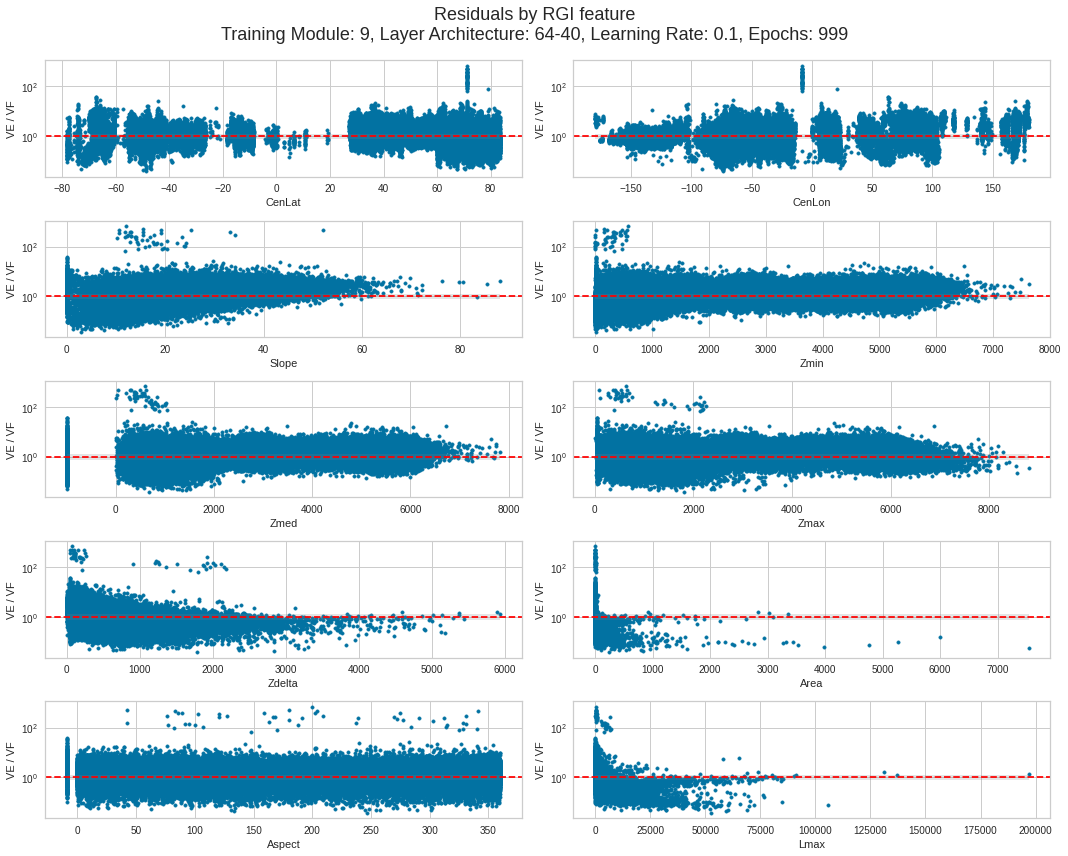

In [16]:
fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Residuals by RGI feature' + 
    '\nTraining Module: ' + predictions['training module'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
    ', Epochs: ' + predictions['epochs'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')
dft = ref[[
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Zdelta',
    'Area',
    'Aspect',
    'Lmax',

]]
for n, variable in enumerate(dft):
    ax = plt.subplot(5, 2, n + 1)
    plt.subplots_adjust(hspace=0.5)
    ax.set_ylabel('VE / VF')
    ax.set_xlabel(variable)
    ax.set_yscale('log')
    plt.scatter(
        dft[variable],
        ref['VE / VF'],
        marker = '.'
    )
    ax.fill_between(
        x = (
            dft[variable].min(), dft[variable].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')

plt.tight_layout()

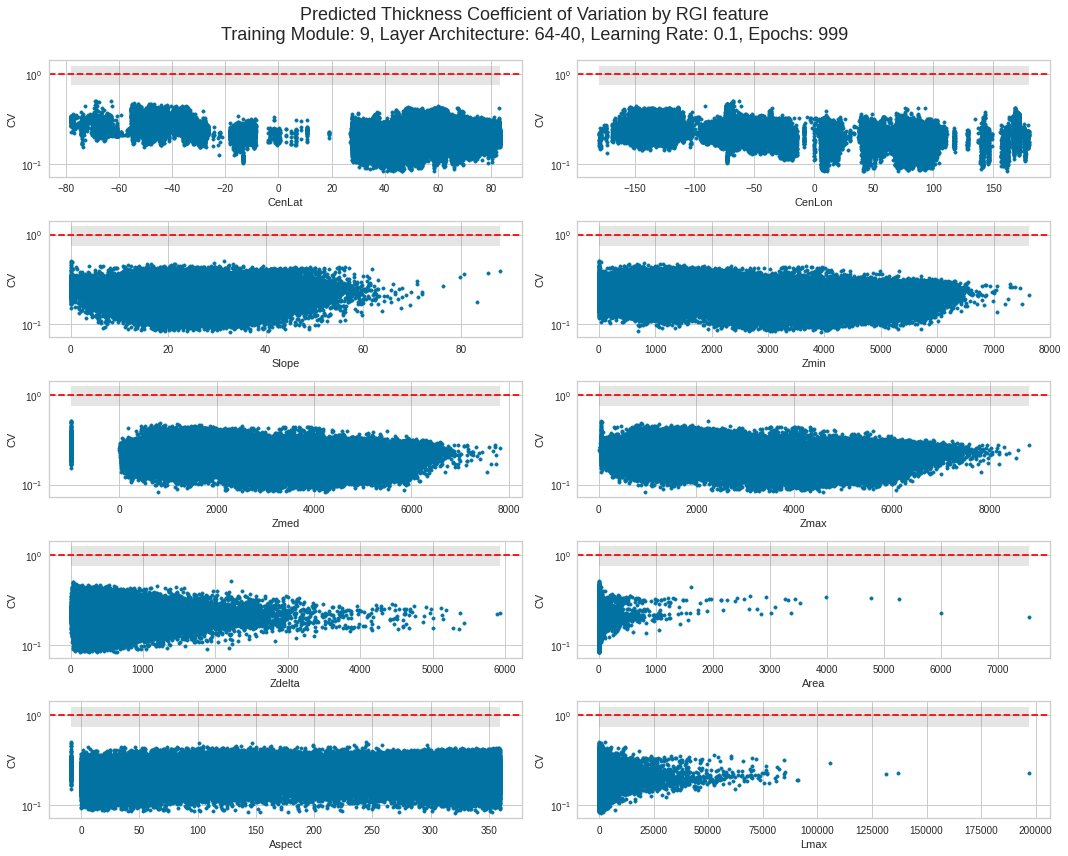

In [17]:
fig = plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Predicted Thickness Coefficient of Variation by RGI feature' + 
    '\nTraining Module: ' + predictions['training module'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
    ', Epochs: ' + predictions['epochs'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')
dft = ref[[
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Zdelta',
    'Area',
    'Aspect',
    'Lmax',

]]

for n, variable in enumerate(dft):

    ax = plt.subplot(5, 2, n + 1)
    plt.subplots_adjust(hspace=0.5)
    ax.set_ylabel('CV')
    ax.set_xlabel(variable)
    ax.set_yscale('log')
    plt.scatter(
        dft[variable],
        (ref[['0', '1', '2', '3','4','5','6','7','8','9','10',
          '11','12','13','14','15','16','17','18','19','20',
          '21','22','23','24']].std(axis = 1)) / ref[['0', '1', '2', '3','4','5','6','7','8','9','10',
          '11','12','13','14','15','16','17','18','19','20',
          '21','22','23','24']].mean(axis = 1) ,
        marker = '.'
    )
    ax.fill_between(
        x = (
            dft[variable].min(), dft[variable].max()
        ),
        y1 = 1.25,
        y2 = 0.75,
        facecolor = 'gray',
        alpha = 0.2
    )
    plt.axhline(y = 1.00, color = 'red', linestyle = '--')

plt.tight_layout()

In [18]:
len(dft)

215487

In [19]:
# import seaborn as sns
# fig = sns.violinplot(x = dft['VE / VF'],
# #                          showmeans = True, 
# #                          vert = True
#                     )
# # fig.show()

In [20]:

# import plotly.express as px
# for i in range(0, 2500, 100):
#     print(i)
#     dft = ref.loc[
#         (ref['Lmax'].between(i,i + 100))
#     ]
# #     print(dft)
# (x = dft['Lmax'],
#                 y = dft['VE / VF'],
# #                          showmeans = True, 
# #                          vert = True
#                     )
#     fig.show()
#     break

In [21]:
# density plot
# fig = plt.figure(figsize=(15, 12))
# plt.subplots_adjust(hspace=0.5)
# plt.suptitle('Residuals by RGI feature' + 
#     '\nTraining Module: ' + predictions['training module'].loc[idx] + 
#     ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
#     ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
#     ', Epochs: ' + predictions['epochs'].loc[idx], fontsize=18, y=0.99)
# fig.patch.set_facecolor('w')
# dft = ref[[
#     'CenLat',
#     'CenLon',
#     'Slope',
#     'Zmin',
#     'Zmed',
#     'Zmax',
#     'Zdelta',
#     'Area',
#     'Aspect',
#     'Lmax',

# ]]
# for region_number in tqdm((range(1,20,1))):
#     if len(str(region_number)) == 1:
#         N = 1
#         region_number = str(region_number).zfill(N + len(str(region_number)))
#     else:
#         str(region_number) == str(region_number)
    



# for n, variable in enumerate(dft):
#     ax = plt.subplot(5, 2, n + 1)
#     plt.subplots_adjust(hspace=0.5)
#     ax.set_ylabel('VE / VF')
#     ax.set_xlabel(variable)
#     ax.set_yscale('log')
#     sns.kdeplot(
#         dft[variable],
#         ref['VE / VF'],
#         fill = True
#     )
#     ax.fill_between(
#         x = (
#             dft[variable].min(), dft[variable].max()
#         ),
#         y1 = 1.25,
#         y2 = 0.75,
#         facecolor = 'gray',
#         alpha = 0.2
#     )
#     plt.axhline(y = 1.00, color = 'red', linestyle = '--')

# plt.tight_layout()

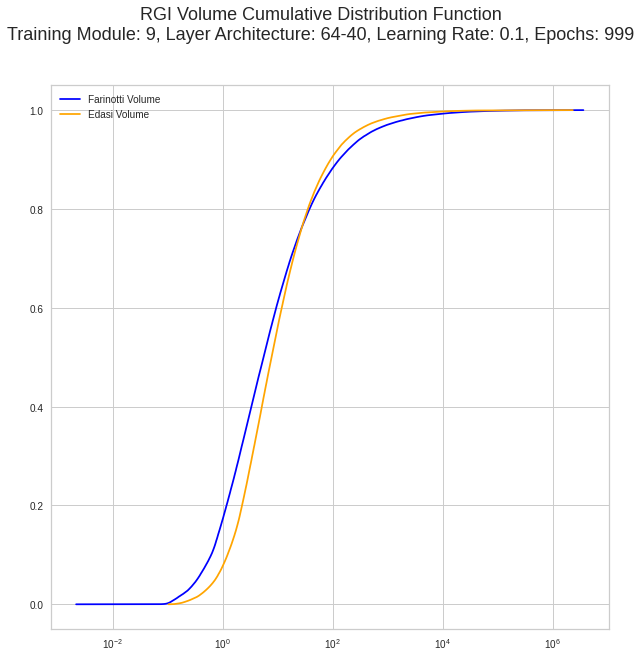

In [22]:
data_1 = ref['Farinotti Mean Thickness'] * ref['Area']
data_2 = ref['Edasi Mean Thickness'] * ref['Area']
#sort data


x_1 = np.sort(data_1)
# x = data_1
#calculate CDF values
y_1 = 1. * np.arange(len(data_1)) / (len(data_1) - 1)


x_2 = np.sort(data_2)
# x = data
#calculate CDF values
y_2 = 1. * np.arange(len(data_2)) / (len(data_2) - 1)

#plot CDF
fig, ax = plt.subplots(1,1,figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)
plt.suptitle('RGI Volume Cumulative Distribution Function' + 
    '\nTraining Module: ' + predictions['training module'].loc[idx] + 
    ', Layer Architecture: ' + predictions['architecture'].loc[idx] +
    ', Learning Rate: ' + predictions['learning rate'].loc[idx] + 
    ', Epochs: ' + predictions['epochs'].loc[idx], fontsize=18, y=0.99)
fig.patch.set_facecolor('w')
plt.subplots_adjust(hspace=0.5)
plt.plot(
    x_1, 
    y_1,
    c = 'blue',
    label = 'Farinotti Volume'
    
)
plt.plot(
    x_2, 
    y_2,
    c = 'orange',
    label = 'Edasi Volume'
)
plt.legend()
ax.set_xscale('log')